In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import math
import os


from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
from numpy import mean
from numpy import std

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
raw_df=pd.read_excel("orders.xlsx")
raw_df.head()

,order_id,customer_id,merchant_id,order_amount,checkout_started_at,credit_decision_started_at,approved_for_installments,customer_credit_score,customer_age,customer_billing_zip,customer_shipping_zip,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
0,42C39B,9D74A0,6881F9,147.20,2018-10-03 14:26:18.497,2018-10-03 14:26:18.997,True,626,26,95407,95407,1.0,1,1.0,1.0
1,A19AC4,2629AB,C37828,69.95,2018-09-21 16:55:03.443,2018-09-21 16:55:05.100,True,603,20,85007,85007,1.0,1,1.0,1.0
2,381AFF,793FE0,252600000000,45.00,2018-09-15 13:41:46.103,2018-09-15 13:41:47.197,True,648,41,30305-2646,30305-2646,1.0,1,1.0,1.0
3,3184A3,22C696,24FBAF,164.00,2018-10-10 00:59:25.793,2018-10-10 00:59:26.123,True,625,33,28562,28562,1.0,1,1.0,1.0
4,237711,D4E94A,6F498E,69.17,2018-09-12 22:53:08.970,2018-09-12 22:53:10.923,True,438,18,92324,92324,1.0,1,1.0,1.0


In [3]:
raw_df.shape

(10000, 15)

In [4]:
raw_df.isnull().sum()

order_id                        0
customer_id                     0
merchant_id                     0
order_amount                    0
checkout_started_at             0
credit_decision_started_at      0
approved_for_installments       0
customer_credit_score           0
customer_age                    0
customer_billing_zip           11
customer_shipping_zip          23
paid_installment_1              2
paid_installment_2              0
paid_installment_3              4
paid_installment_4            577
dtype: int64

In [5]:
df=raw_df.copy()

In [6]:
variables_with_na=[var for var in df.columns if df[var].isnull().sum()>1]
for var in variables_with_na:
    print("column ", var,"having ",np.round(df[var].isnull().mean(),3),"% missing values")

column  customer_billing_zip having  0.001 % missing values
column  customer_shipping_zip having  0.002 % missing values
column  paid_installment_1 having  0.0 % missing values
column  paid_installment_3 having  0.0 % missing values
column  paid_installment_4 having  0.058 % missing values


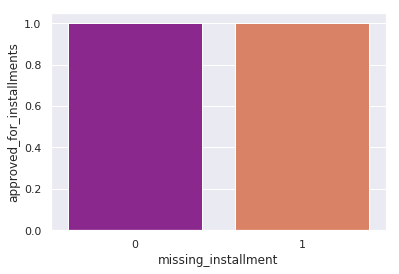

In [7]:
missing_df=df.copy()
missing_df["missing_installment"]=np.where(df["paid_installment_4"].isnull(),1,0)
sns.set_style('darkgrid')
# plot the graph using the default estimator mean
sns.barplot(x ='missing_installment', y ='approved_for_installments', data = missing_df, palette ='plasma');
# there is no imbalance in the null values in dataset

In [8]:
count_series = missing_df.groupby(["approved_for_installments","missing_installment"]).size()
new_df = count_series.to_frame(name = 'size').reset_index()
#missing_df[missing_df["missing_installment"]==1]

In [9]:
#check any columns are having values more than 10 percent
null_columns=df.isnull().sum()
null_columns=null_columns[null_columns.values>(0.1*len(df))]
len(null_columns)

0

In [10]:
# there are no null values for each columns with more than 10 percent. so we drop the null values
df=df.dropna()

In [11]:
df.shape

(9395, 15)

In [12]:
#for checking the outliers
df.describe()

,order_amount,customer_credit_score,customer_age,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
count,9395.000000,9395.000000,9395.000000,9395.0,9395.000000,9395.000000,9395.000000
mean,145.556299,613.268866,33.583608,1.0,0.977754,0.959872,0.940181
std,168.269974,93.022457,12.012152,0.0,0.147490,0.196269,0.237164
min,4.950000,1.000000,18.000000,1.0,0.000000,0.000000,0.000000
25%,63.945000,562.000000,24.000000,1.0,1.000000,1.000000,1.000000
50%,89.980000,611.000000,30.000000,1.0,1.000000,1.000000,1.000000
75%,154.810000,664.000000,41.000000,1.0,1.000000,1.000000,1.000000
max,1936.000000,836.000000,89.000000,1.0,1.000000,1.000000,1.000000


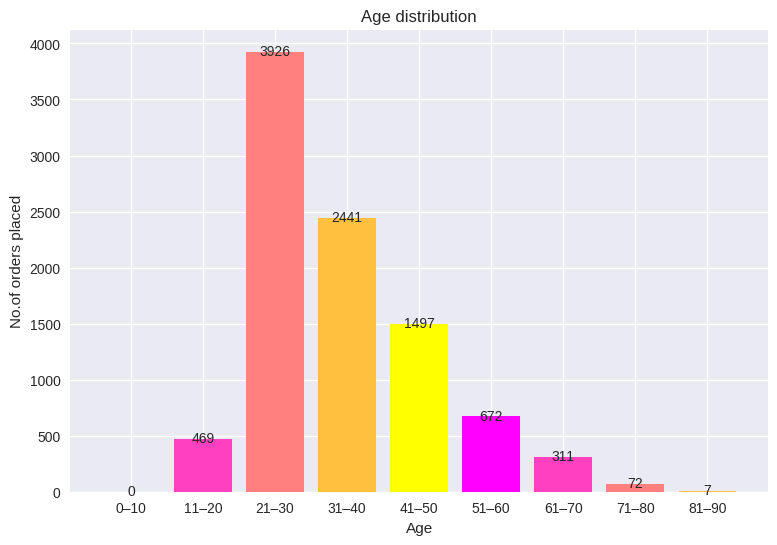

<Figure size 800x550 with 0 Axes>

In [71]:
plt.rcParams['figure.figsize'] = (9, 6)

plt.style.use('seaborn')

ages = df['customer_age'].values
ages_hist = np.histogram(ages, bins=[0,10,20,30,40,50,60,70,80,90])
ages_hist_labels = ['0–10','11–20', '21–30', '31–40', '41–50', '51–60', '61–70', '71–80', '81–90']
plt.figure(figsize=(9,6))
plt.title('Age distribution')
color = plt.cm.spring(np.linspace(0, 1, 5))
plt.bar(ages_hist_labels, ages_hist[0],color=color)
plt.xlabel('Age')
plt.ylabel('No.of orders placed')

for i, bin in zip(ages_hist[0], range(9)):
    plt.text(bin, i+3, str(int(i)), fontsize=10,
             horizontalalignment='center', verticalalignment='center')
plt.show();
plt.savefig(os.path.join('Agewise_customer_distribution.jpg'), dpi=200, format='png', bbox_inches='tight')

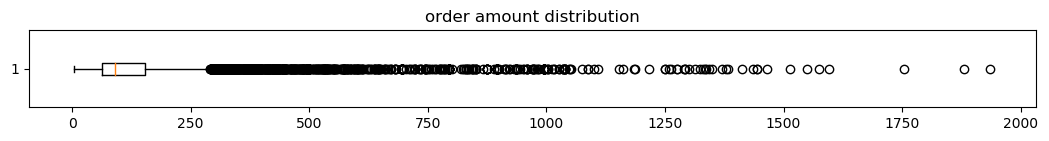

<Figure size 640x480 with 0 Axes>

In [72]:
plt.figure(figsize=(13,1))
plt.rcParams.update(plt.rcParamsDefault)
plt.title('order amount distribution')
plt.boxplot(df['order_amount'], vert=False)
plt.show()
plt.savefig(os.path.join('order_amount_distribution.png'), dpi=300, format='png', bbox_inches='tight')

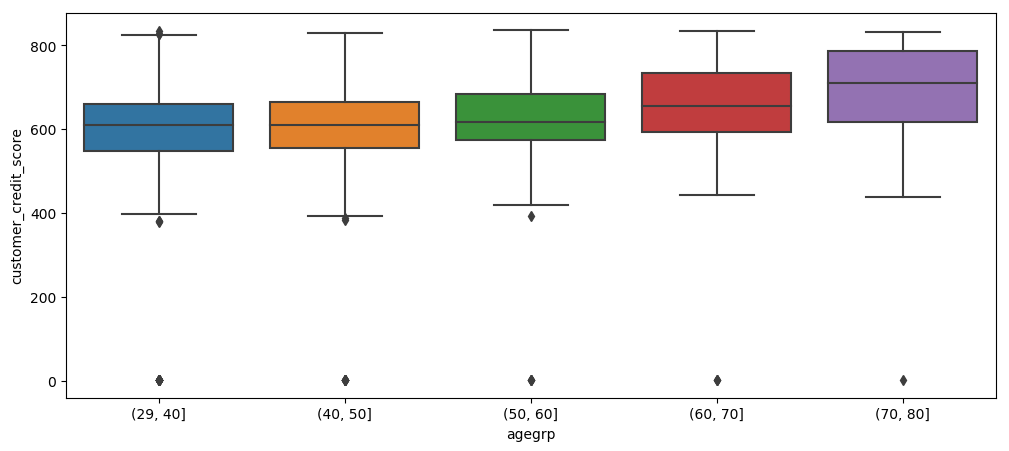

In [15]:
df["agegrp"]=pd.cut(df.customer_age, [29,40,50,60,70,80])
plt.figure(figsize=(12,5))
plt.rcParams.update(plt.rcParamsDefault)
sns.boxplot(x = "agegrp", y = "customer_credit_score", data=df)
plt.savefig(os.path.join('Age_vs_Customer_credit_score.png'), dpi=300, format='png', bbox_inches='tight')

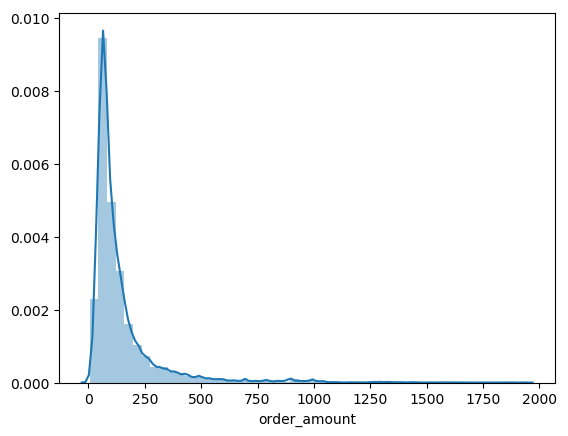

In [16]:
sns.distplot(df.order_amount.dropna())


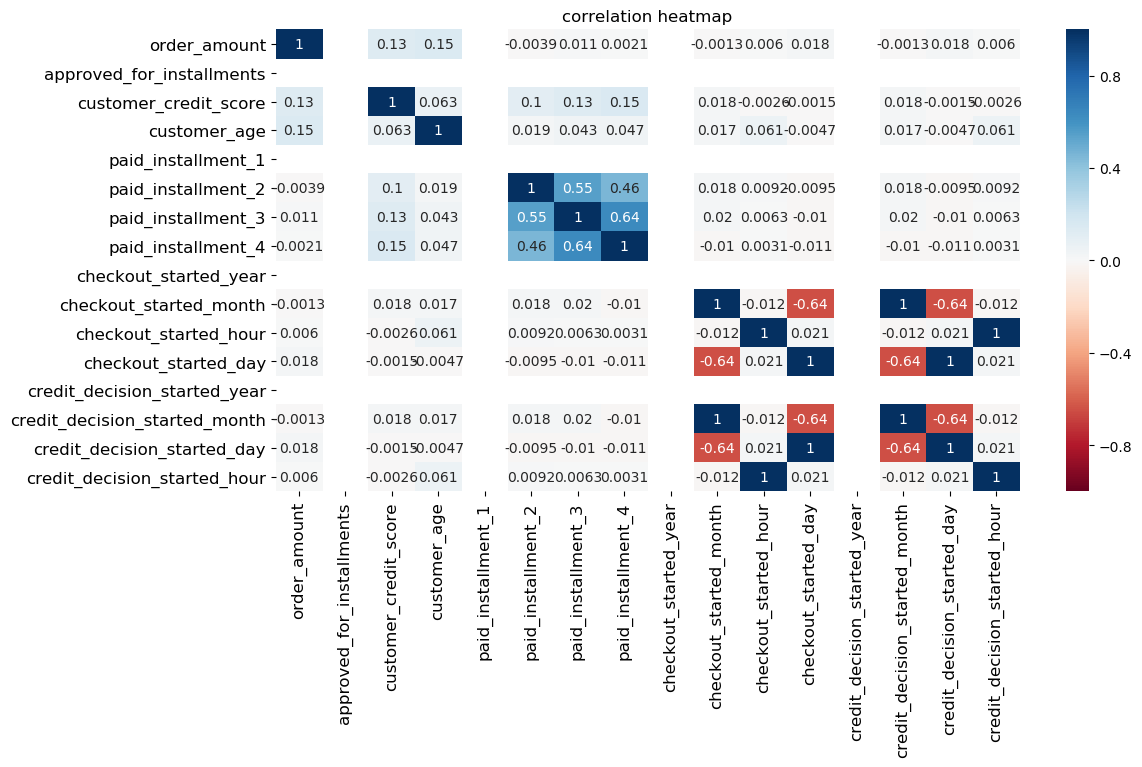

<Figure size 640x480 with 0 Axes>

In [80]:
plt.figure(figsize=(12,6))
s=sns.heatmap(df.corr(),
             annot=True,
             cmap='RdBu',
             vmax=-1,
             vmin=1)
s.set_yticklabels(s.get_yticklabels(),rotation=0,fontsize=12)
s.set_xticklabels(s.get_xticklabels(),rotation=90,fontsize=12)
plt.title("correlation heatmap")
plt.show()
plt.savefig('correlation_plot.png', dpi=300, format='png', bbox_inches='tight')

In [18]:
def outlier_detection(data):
    data_mean, data_std = mean(data), std(data)
    # define outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    print( ' Identified outliers: %d ' % len(outliers))

In [19]:
def univariate_analysis(df,col,var_type,hue=None):
    sns.set(style='darkgrid')
    if var_type=="numeric":
        fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,8))
        ax[0].set_title("Distribution plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Box plot")
        sns.boxplot(data=df,x=col,ax=ax[1],orient='v')
    if var_type=="category":
        temp=pd.Series(data=hue)
        fig,ax=plt.subplots()
        width=len(df[col].unique())+6+4*len(temp.unique())
        fig.set_size_inches(width,7)
        ax=sns.countplot(data=df,x=col,order=df[col].value_counts().index,hue=hue)
    else:
        pass
    plt.show();

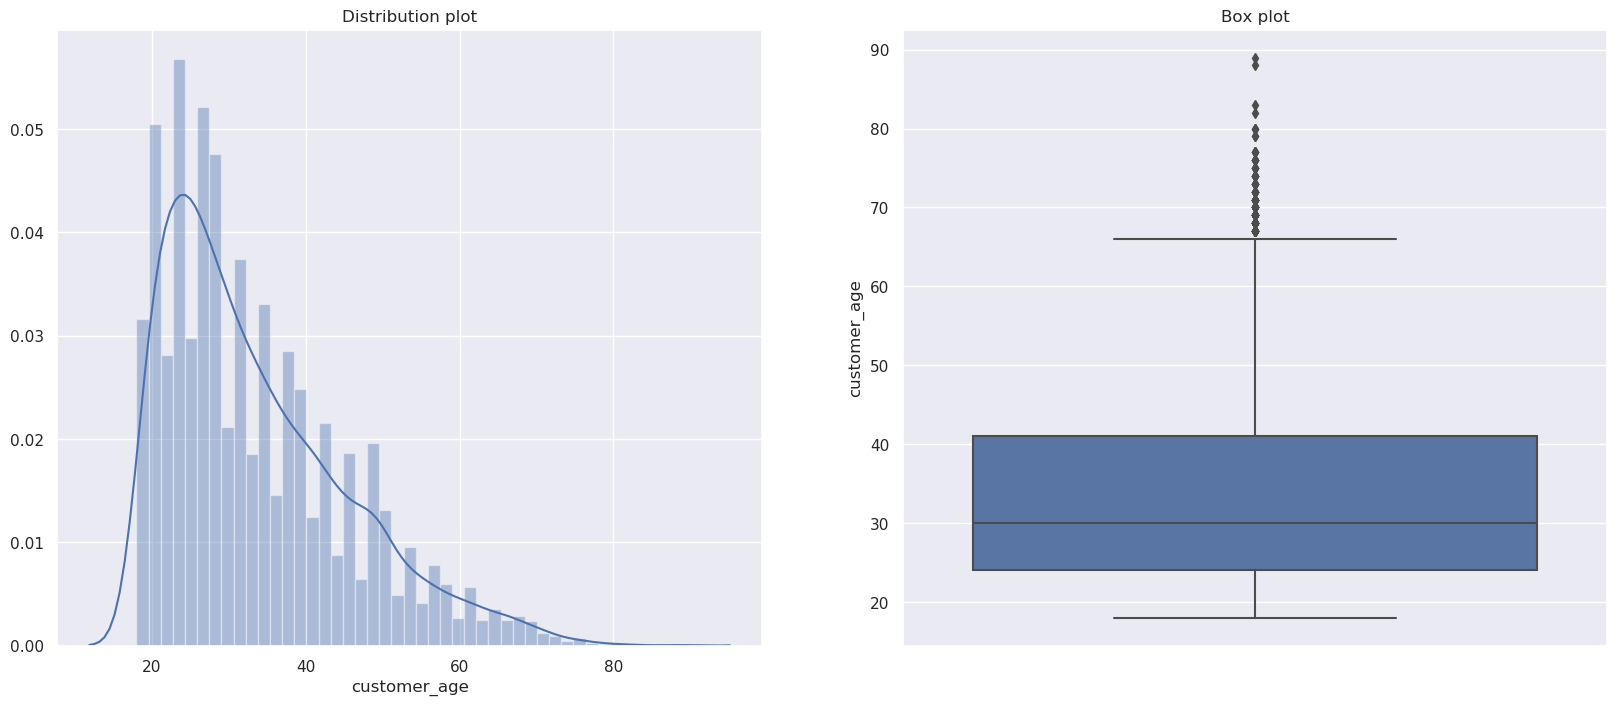

<Figure size 640x480 with 0 Axes>

In [20]:
univariate_analysis(df=df,col='customer_age',var_type='numeric')
plt.savefig(os.path.join('univariate_customer_age.png'), dpi=300, format='png', bbox_inches='tight')

In [21]:
outlier_detection(df["customer_age"])

 Identified outliers: 79 


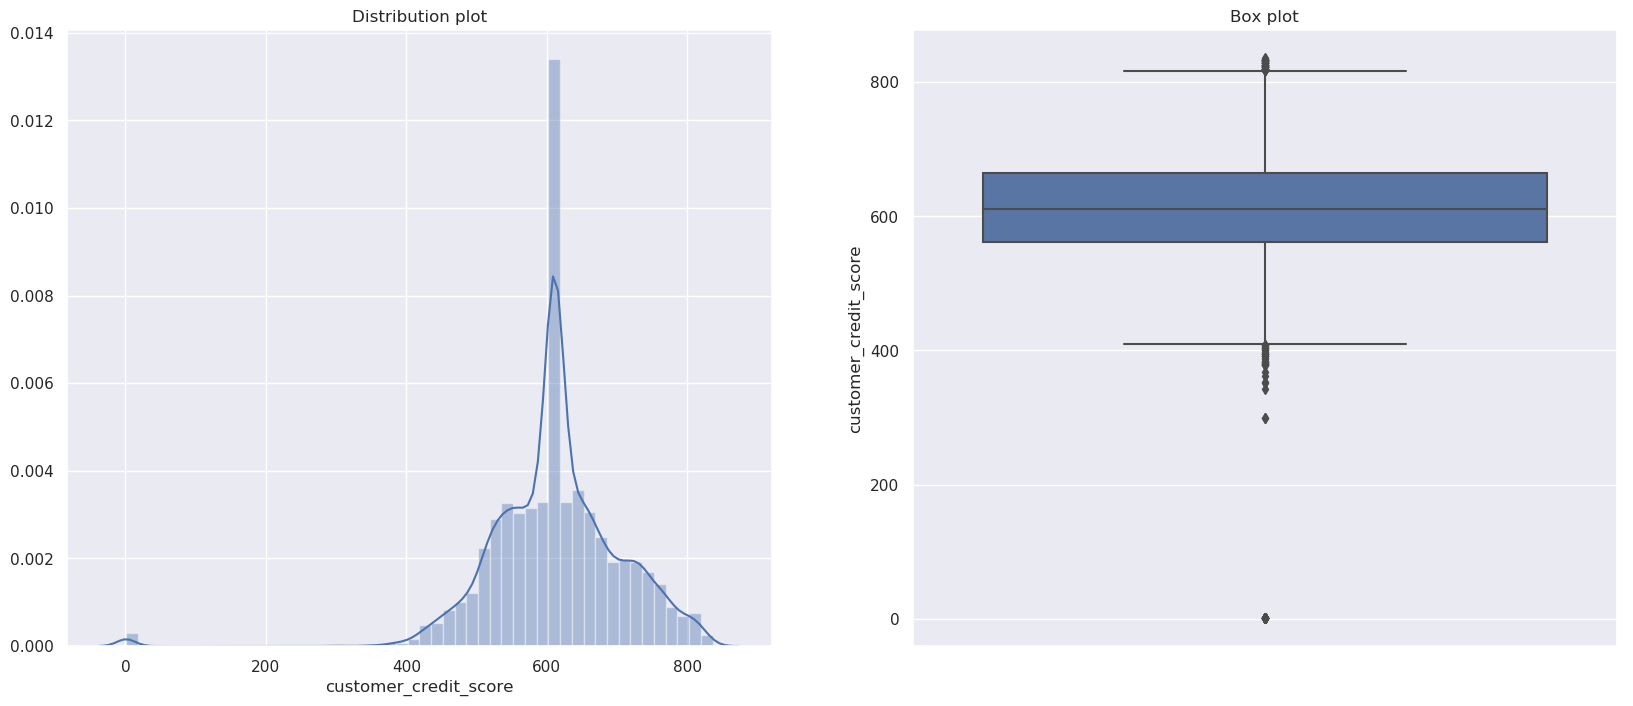

<Figure size 640x480 with 0 Axes>

In [22]:
univariate_analysis(df=df,col='customer_credit_score',var_type='numeric')
plt.savefig(os.path.join('univariate_customer_credit_score.png'), dpi=300, format='png', bbox_inches='tight')

In [23]:
outlier_detection(df["customer_credit_score"])

 Identified outliers: 50 


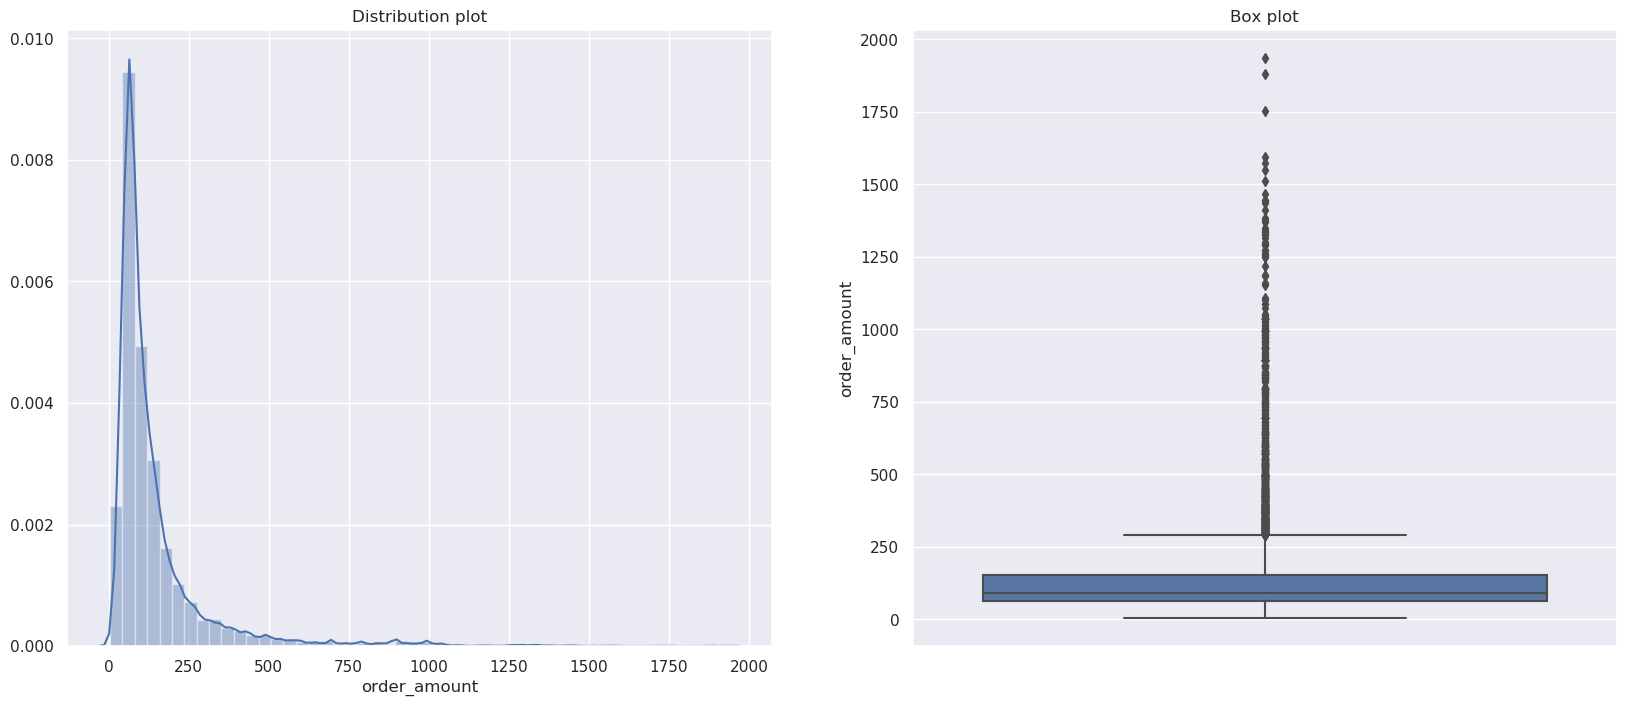

<Figure size 640x480 with 0 Axes>

In [24]:
univariate_analysis(df=df,col='order_amount',var_type='numeric')
plt.savefig(os.path.join('univariate_order_amount.png'), dpi=300, format='png', bbox_inches='tight')

In [25]:
outlier_detection(df["order_amount"])

 Identified outliers: 245 


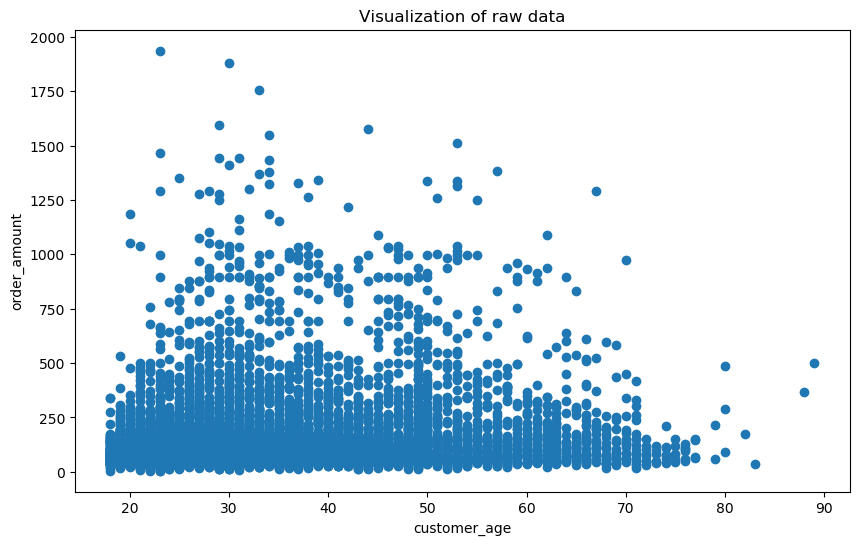

In [81]:
plt.figure(figsize=(10,6))
plt.scatter(df["customer_age"],df["order_amount"])
plt.xlabel("customer_age")
plt.ylabel("order_amount")
plt.title("Visualization of raw data");
#plt.savefig(os.path.join('Age_Vs_order_amount.png'), dpi=300, format='png', bbox_inches='tight')

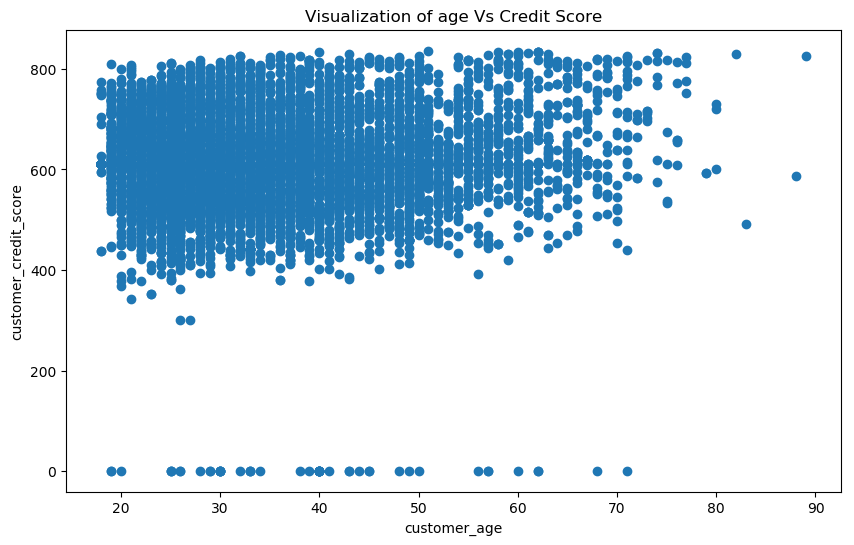

In [82]:
plt.figure(figsize=(10,6))
plt.scatter(df["customer_age"],df["customer_credit_score"])
plt.xlabel("customer_age")
plt.ylabel("customer_credit_score")
plt.title("Visualization of age Vs Credit Score");
#plt.savefig(os.path.join('Age_Vs_credit_score.png'), dpi=300, format='png', bbox_inches='tight')

In [28]:
df['checkout_started_year'] = df.checkout_started_at.dt.year # extratcing the year
df['checkout_started_month'] = df.checkout_started_at.dt.month # extratcing the month
df['checkout_started_hour'] = df.checkout_started_at.dt.hour # extratcing the hour
df['checkout_started_day'] = df.checkout_started_at.dt.day
df['credit_decision_started_year'] = df.credit_decision_started_at.dt.year # extratcing the year
df['credit_decision_started_month'] = df.credit_decision_started_at.dt.month # extratcing the month
df['credit_decision_started_day'] = df.credit_decision_started_at.dt.day
df['credit_decision_started_hour'] = df.credit_decision_started_at.dt.hour # extratcing the hour

checkout_started_month
8      714.0
10    3017.0
9     5664.0
Name: approved_for_installments, dtype: float64

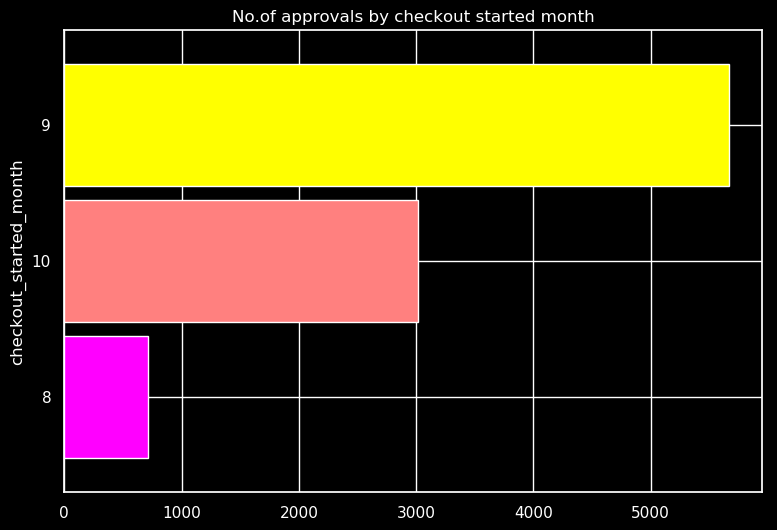

In [29]:
by_checkout_month = df.groupby(['checkout_started_month'])['approved_for_installments'].sum()
by_checkout_month=by_checkout_month.sort_values()
plt.style.use('dark_background')
color = plt.cm.spring(np.linspace(0, 1,3))
by_checkout_month.plot(kind='barh', figsize=(9,6),color=color, width=0.9, title="No.of approvals by checkout started month") # returning the figure grouped by year

plt.savefig(os.path.join('month_wise_distribution.png'), dpi=300, format='png', bbox_inches='tight')
by_checkout_month

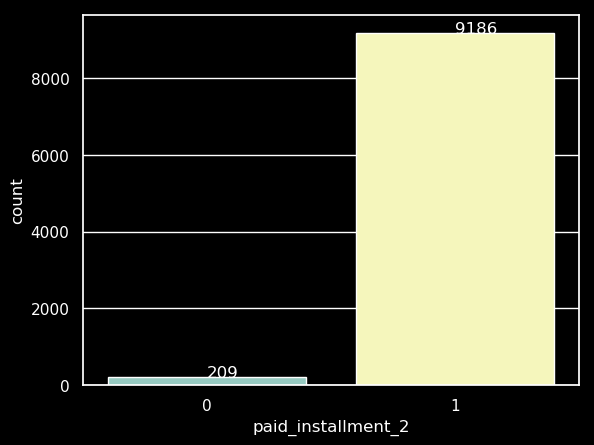

In [30]:
sns.countplot(df.paid_installment_2);
for v in [0, 1]:
    plt.text(v, (df.paid_installment_2 == v).sum(), str((df.paid_installment_2 == v).sum()));
plt.savefig(os.path.join('2nd_installment_payment.png'), dpi=300, format='png', bbox_inches='tight')

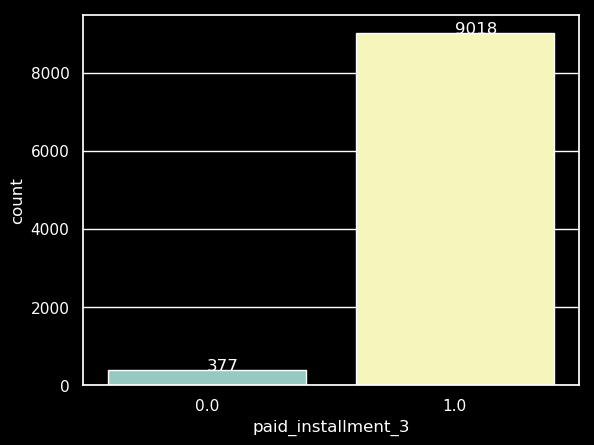

In [31]:
sns.countplot(df.paid_installment_3);
for v in [0, 1]:
    plt.text(v, (df.paid_installment_3 == v).sum(), str((df.paid_installment_3 == v).sum()));
plt.savefig(os.path.join('3rd_installment_payment.png'), dpi=300, format='png', bbox_inches='tight')

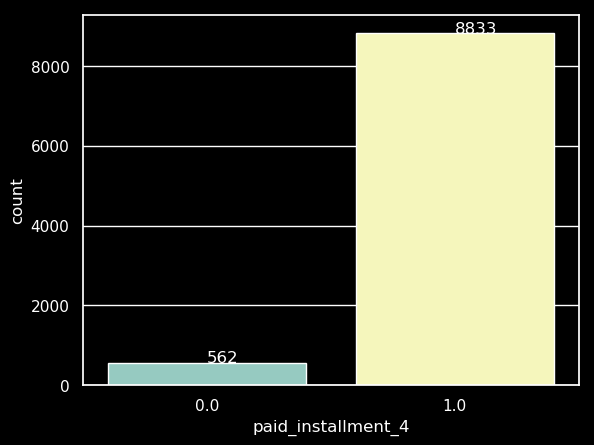

In [32]:
sns.countplot(df.paid_installment_4);
for v in [0, 1]:
    plt.text(v, (df.paid_installment_4 == v).sum(), str((df.paid_installment_4 == v).sum()));
plt.savefig(os.path.join('4th_installment_payment.png'), dpi=300, format='png', bbox_inches='tight')

credit_decision_started_month
8      714.0
10    3017.0
9     5664.0
Name: approved_for_installments, dtype: float64

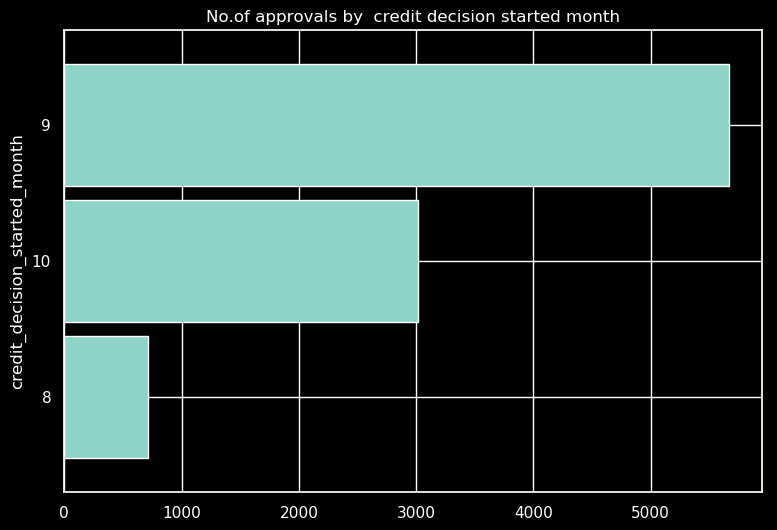

In [33]:
by_credit_decision_month = df.groupby(['credit_decision_started_month'])['approved_for_installments'].sum()
by_credit_decision_month=by_credit_decision_month.sort_values()
by_credit_decision_month.plot(kind='barh', figsize=(9,6), width=0.9, title="No.of approvals by  credit decision started month") # returning the figure grouped by year

by_credit_decision_month

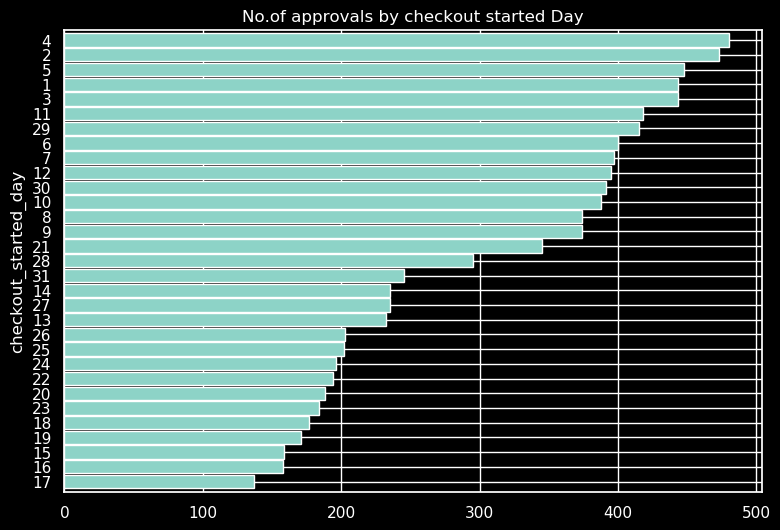

In [34]:
by_checkout_day = df.groupby(['checkout_started_day'])['approved_for_installments'].sum()
by_checkout_day=by_checkout_day.sort_values()
by_checkout_day.plot(kind='barh', figsize=(9,6), width=0.9, title="No.of approvals by checkout started Day"); # returning the figure grouped by day

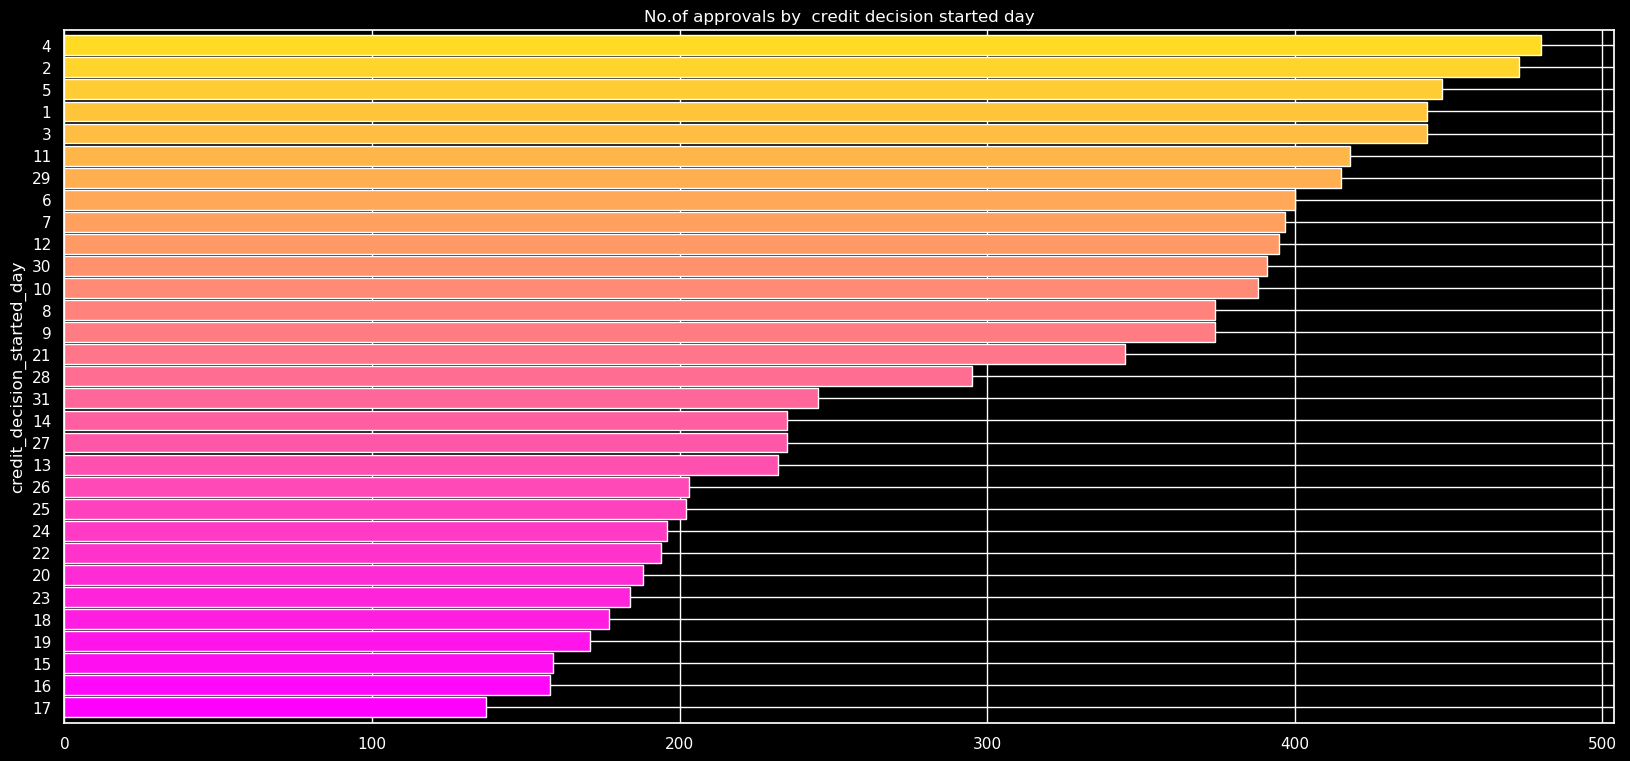

In [35]:
by_credit_decision_day= df.groupby(['credit_decision_started_day'])['approved_for_installments'].sum()
by_credit_decision_day=by_credit_decision_day.sort_values()
color = plt.cm.spring(np.linspace(0, 1, 36))
by_credit_decision_day.plot(kind='barh', figsize=(20, 9), color=color,width=0.9, title="No.of approvals by  credit decision started day");
# returning the figure grouped by day
plt.savefig(os.path.join('Order_based_on_day_of_month.png'), dpi=300, format='png', bbox_inches='tight')

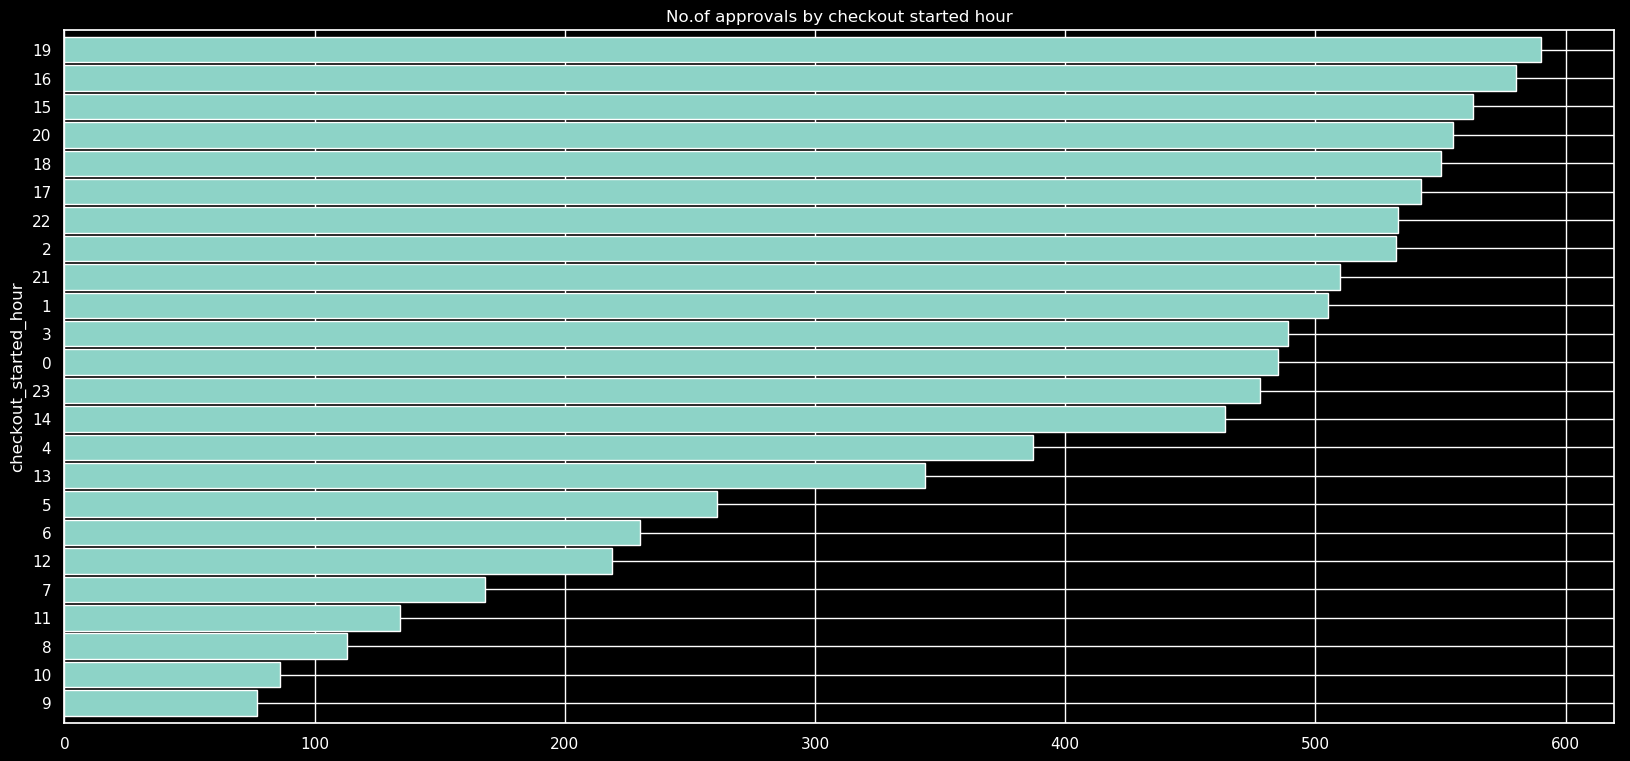

In [36]:
by_checkout_hour = df.groupby(['checkout_started_hour'], as_index=True)["approved_for_installments"].count()
by_checkout_hour=by_checkout_hour.sort_values()
by_checkout_hour.plot(kind='barh', figsize=(20,9), width=0.9, title="No.of approvals by checkout started hour") # returning the figure grouped by hour

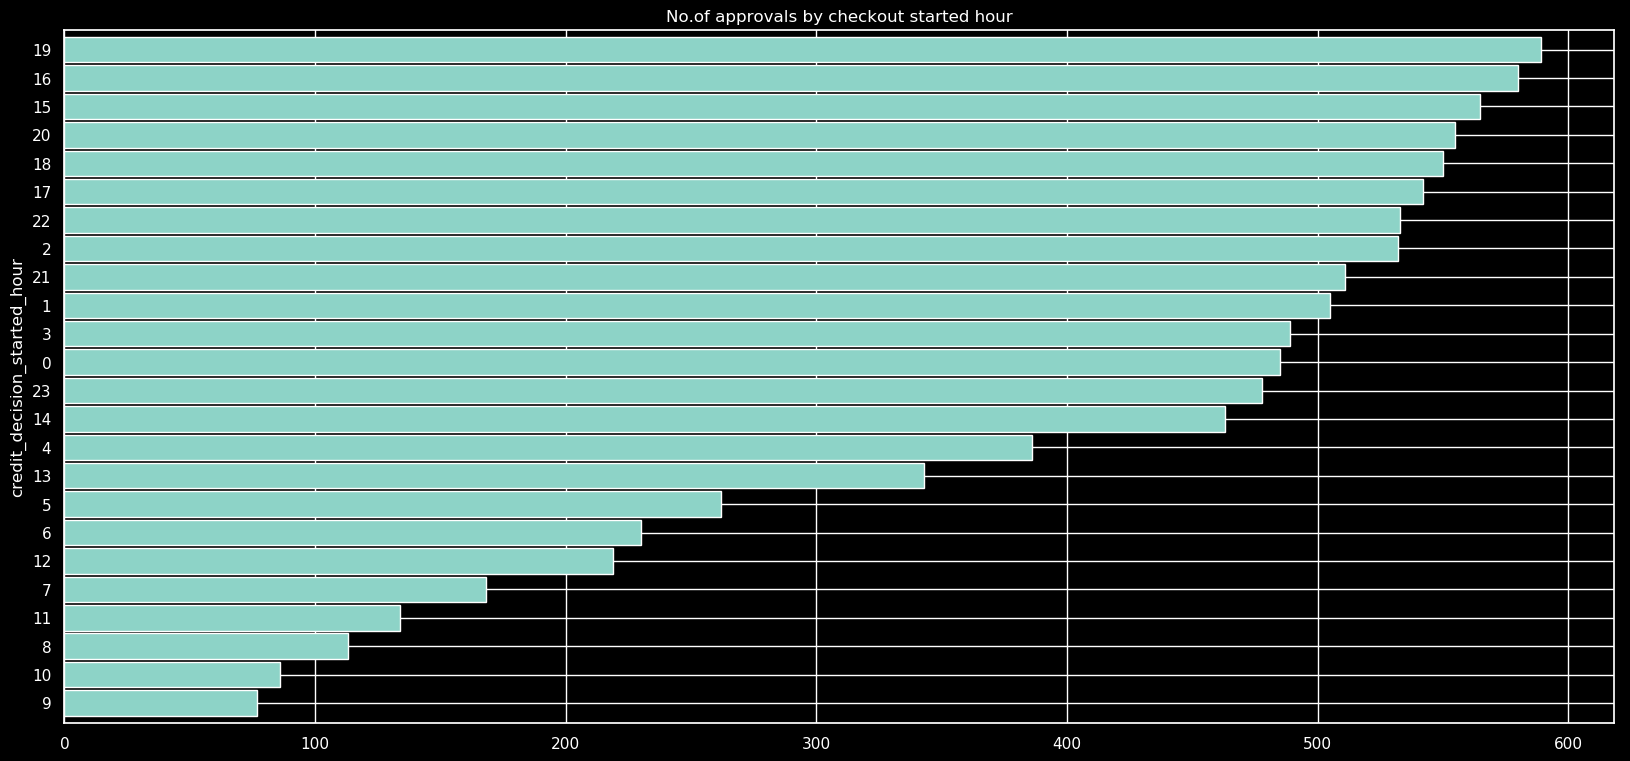

In [37]:
by_credit_decision_hour = df.groupby(['credit_decision_started_hour'], as_index=True)["approved_for_installments"].count()
by_credit_decision_hour=by_credit_decision_hour.sort_values()
by_credit_decision_hour.plot(kind='barh', figsize=(20,9), width=0.9, title="No.of approvals by checkout started hour"); # returning the figure grouped by hour
plt.savefig(os.path.join('Order_based_on_day_of_hour.png'), dpi=300, format='png', bbox_inches='tight')

In [38]:
df.customer_id.nunique()
# as there are too many unique customers details, its better to segment them based on similar properties and then analyse them

8428

In [39]:
print(df.columns.tolist(),end=" ")

['order_id', 'customer_id', 'merchant_id', 'order_amount', 'checkout_started_at', 'credit_decision_started_at', 'approved_for_installments', 'customer_credit_score', 'customer_age', 'customer_billing_zip', 'customer_shipping_zip', 'paid_installment_1', 'paid_installment_2', 'paid_installment_3', 'paid_installment_4', 'agegrp', 'checkout_started_year', 'checkout_started_month', 'checkout_started_hour', 'checkout_started_day', 'credit_decision_started_year', 'credit_decision_started_month', 'credit_decision_started_day', 'credit_decision_started_hour'] 

In [40]:
df_Segmentation=df[['customer_id','order_amount', 'customer_credit_score', 'customer_age', 'paid_installment_2', 'paid_installment_3', 'paid_installment_4', 'approved_for_installments', 'checkout_started_month','checkout_started_day']]
cols_to_standardize=['order_amount', 'customer_credit_score', 'customer_age', 'paid_installment_2', 'paid_installment_3', 'paid_installment_4', 'approved_for_installments', 'checkout_started_month','checkout_started_day']

In [41]:
scaler=StandardScaler()
std_segmentation=scaler.fit_transform(df_Segmentation[cols_to_standardize])

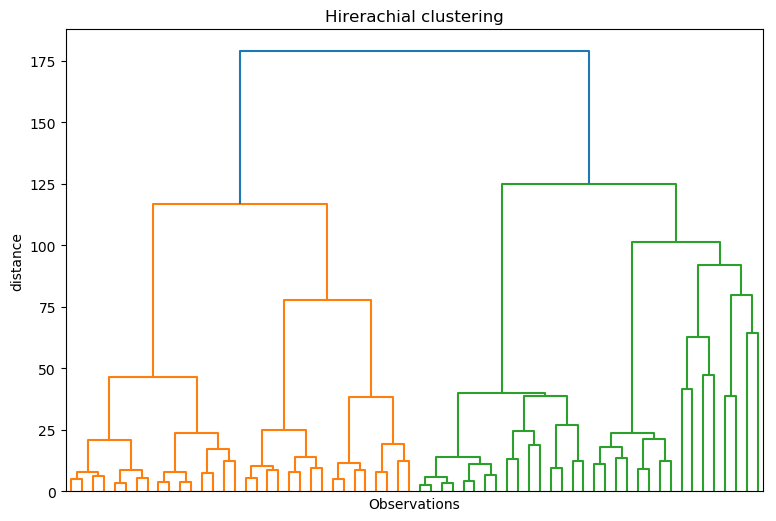

<Figure size 640x480 with 0 Axes>

In [83]:
#finding out no.of clusters using dendrogram
hier_cluster=linkage(std_segmentation,method='ward')# this method return clustering results in the linkage matrix
plt.figure(figsize=(9,6))
plt.title("Hirerachial clustering")
plt.xlabel("Observations")
plt.ylabel("distance")
dendrogram(hier_cluster,
           truncate_mode='level',
           p=5,
          show_leaf_counts=False,
          no_labels=True)
plt.show()
plt.savefig(os.path.join('dendrogram.png'), dpi=300, format='png', bbox_inches='tight')

In [43]:
# finding out no.of clusters using k-means
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(std_segmentation)
    wcss.append(kmeans.inertia_)

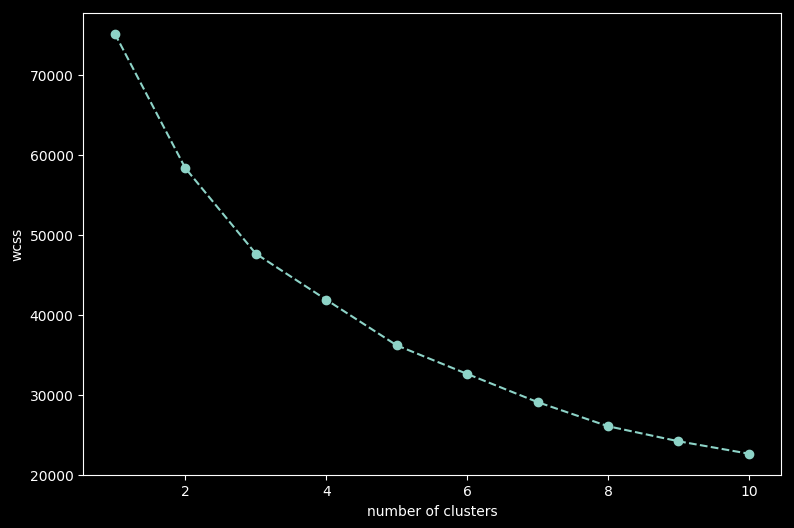

<Figure size 640x480 with 0 Axes>

In [88]:
plt.figure(figsize=(9,6))
plt.style.use('dark_background')
plt.text(0.5, 0.5, '',color="white")
plt.plot(range(1,11),wcss,marker='o',linestyle="--")
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()
plt.savefig(os.path.join('elbow_method.png'), dpi=300, format='png', bbox_inches='tight')

In [45]:
kmeans=KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans.fit(std_segmentation)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [46]:
df_Seg_kmeans=df_Segmentation.copy()
df_Seg_kmeans["segment_k-means"]=kmeans.labels_

In [47]:
df_seg_analysis=df_Seg_kmeans.groupby(["segment_k-means"]).mean()
df_seg_analysis

,order_amount,customer_credit_score,customer_age,paid_installment_2,paid_installment_3,paid_installment_4,approved_for_installments,checkout_started_month,checkout_started_day
segment_k-means,,,,,,,,,
0,140.578397,615.260552,33.668831,0.998377,1.000000,0.970982,True,9.589083,6.442776
1,152.319607,616.825221,33.726893,0.995329,0.999754,0.976647,True,8.833088,23.243363
2,138.082531,552.411028,31.070175,0.543860,0.057644,0.187970,True,9.197995,14.571429


In [48]:
df_seg_analysis["N obeservations"]=df_Seg_kmeans[["segment_k-means","approved_for_installments"]].groupby(["segment_k-means"]).count()

In [49]:
df_seg_analysis["proportion_of_obs"]=df_seg_analysis["N obeservations"]/df_seg_analysis["N obeservations"].sum()

In [50]:
df_seg_analysis

,order_amount,customer_credit_score,customer_age,paid_installment_2,paid_installment_3,paid_installment_4,approved_for_installments,checkout_started_month,checkout_started_day,N obeservations,proportion_of_obs
segment_k-means,,,,,,,,,,,
0,140.578397,615.260552,33.668831,0.998377,1.000000,0.970982,True,9.589083,6.442776,4928,0.524534
1,152.319607,616.825221,33.726893,0.995329,0.999754,0.976647,True,8.833088,23.243363,4068,0.432996
2,138.082531,552.411028,31.070175,0.543860,0.057644,0.187970,True,9.197995,14.571429,399,0.042469


In [51]:
print(df_seg_analysis.columns.tolist(),end=" ")

['order_amount', 'customer_credit_score', 'customer_age', 'paid_installment_2', 'paid_installment_3', 'paid_installment_4', 'approved_for_installments', 'checkout_started_month', 'checkout_started_day', 'N obeservations', 'proportion_of_obs'] 

In [52]:
df_seg_analysis=df_seg_analysis[['order_amount', 'customer_credit_score', 'customer_age', 'paid_installment_2', 'paid_installment_3', 'paid_installment_4', 'N obeservations', 'proportion_of_obs','approved_for_installments', 'checkout_started_month', 'checkout_started_day']]

In [53]:
df_seg_analysis=df_seg_analysis.rename({0:"All-Paid",
                       1:"mostly-Paid",
                       2:"Defaulters"})
df_seg_analysis

,order_amount,customer_credit_score,customer_age,paid_installment_2,paid_installment_3,paid_installment_4,N obeservations,proportion_of_obs,approved_for_installments,checkout_started_month,checkout_started_day
segment_k-means,,,,,,,,,,,
All-Paid,140.578397,615.260552,33.668831,0.998377,1.000000,0.970982,4928,0.524534,True,9.589083,6.442776
mostly-Paid,152.319607,616.825221,33.726893,0.995329,0.999754,0.976647,4068,0.432996,True,8.833088,23.243363
Defaulters,138.082531,552.411028,31.070175,0.543860,0.057644,0.187970,399,0.042469,True,9.197995,14.571429


In [54]:
df_Seg_kmeans["labels"]=df_Seg_kmeans["segment_k-means"].map({0:"All-Paid",
                       1:"mostly-Paid",
                       2:"Defaulters"})

In [55]:
df_Seg_kmeans.columns

Index(['customer_id', 'order_amount', 'customer_credit_score', 'customer_age',
       'paid_installment_2', 'paid_installment_3', 'paid_installment_4',
       'approved_for_installments', 'checkout_started_month',
       'checkout_started_day', 'segment_k-means', 'labels'],
      dtype='object')

In [56]:
df_Seg_kmeans["labels"].nunique()

3

In [57]:
df_Seg_kmeans["Mean_Total_installments"]=df_Seg_kmeans["paid_installment_2"]+df_Seg_kmeans["paid_installment_3"]+df_Seg_kmeans["paid_installment_4"]
df_Seg_kmeans["Mean_Total_installments"]=df_Seg_kmeans["Mean_Total_installments"]/3

In [58]:
df_Seg_kmeans["Mean_Total_installments"].unique()

array([1.        , 0.66666667, 0.33333333, 0.        ])

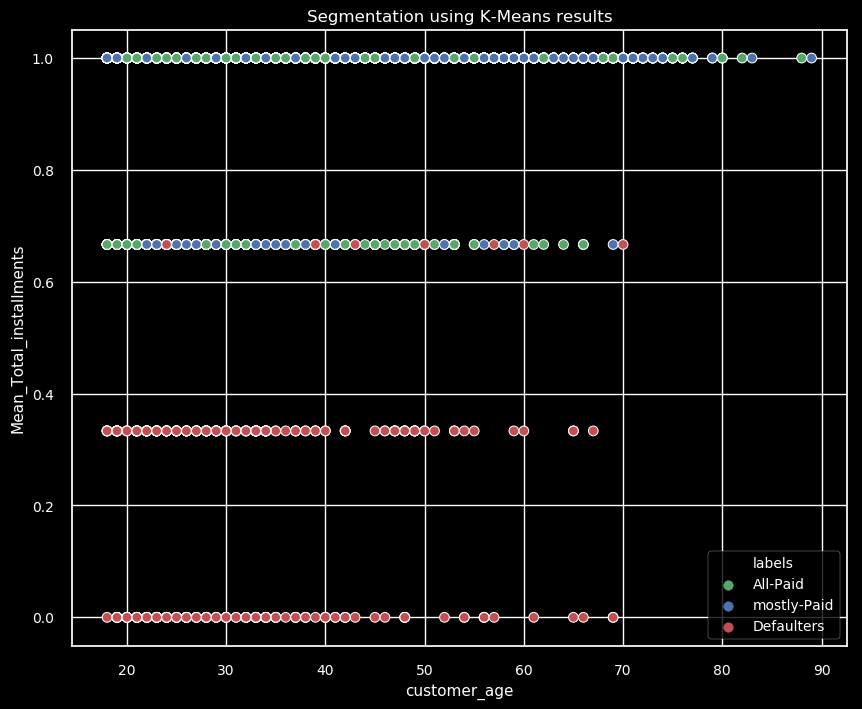

In [59]:
plt.figure(figsize=(10,8))
plt.style.use('seaborn-notebook')
x_axis=df_Seg_kmeans["customer_age"]
y_axis=df_Seg_kmeans["Mean_Total_installments"]
sns.scatterplot(x_axis,y_axis,hue=df_Seg_kmeans["labels"],palette=["g","b","r"])
plt.title("Segmentation using K-Means results")
plt.savefig(os.path.join('KMeans_Segmentation.png'), dpi=300, format='png', bbox_inches='tight')

In [60]:
labels_count = df_Seg_kmeans.groupby('labels')['labels'].count()


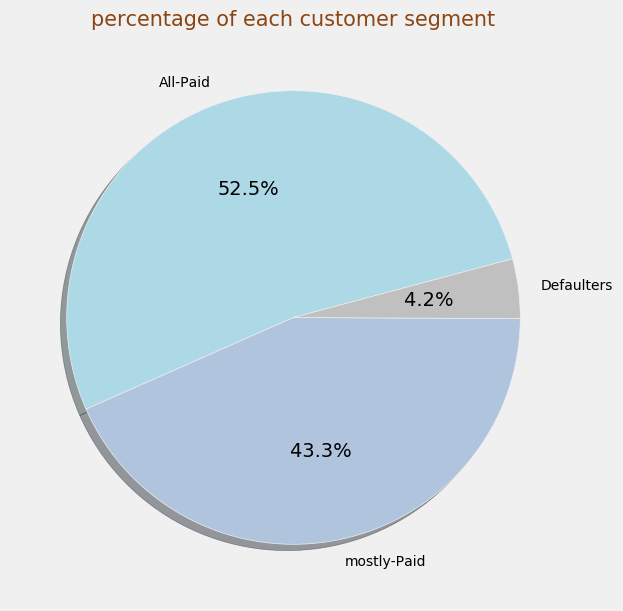

In [61]:
sizes=df_Seg_kmeans.labels.value_counts().values
plt.style.use('fivethirtyeight')
colors=['lightblue','lightsteelblue','silver']
plt.figure(figsize=(12,7))
labels=df_Seg_kmeans.labels.value_counts().index
# plt.pie(sizes,labels=labels,colors=colors,autopct="%1.1f%%")
my_explode = (0, 0.1, 0)
plt.pie(sizes,labels=labels,  autopct='%1.1f%%', startangle=15, shadow = True, colors=colors,textprops={'color':"black"})

plt.title("percentage of each customer segment",color="saddlebrown",fontsize=15)
#plt.savefig(os.path.join('"percentage_of_each_package.png'), dpi=300, format='png', bbox_inches='tight')
plt.savefig(os.path.join('Percentage_split.png'), dpi=300, format='png', bbox_inches='tight')

In [62]:
df_Seg_kmeans["agegrp"]=pd.cut(df.customer_age, [10,20,30,40,50,60,70,80])
temp1=df_Seg_kmeans.groupby('agegrp')["labels"].value_counts().unstack()
temp1

labels,All-Paid,Defaulters,mostly-Paid
agegrp,,,
"(10, 20]",431.0,42.0,340.0
"(20, 30]",2043.0,191.0,1662.0
"(30, 40]",1181.0,101.0,1045.0
"(40, 50]",757.0,39.0,619.0
"(50, 60]",330.0,17.0,247.0
"(60, 70]",159.0,9.0,119.0
"(70, 80]",25.0,NaN,34.0


In [63]:
## 5th category customers are having more defaulters, followed by 4th and so on.

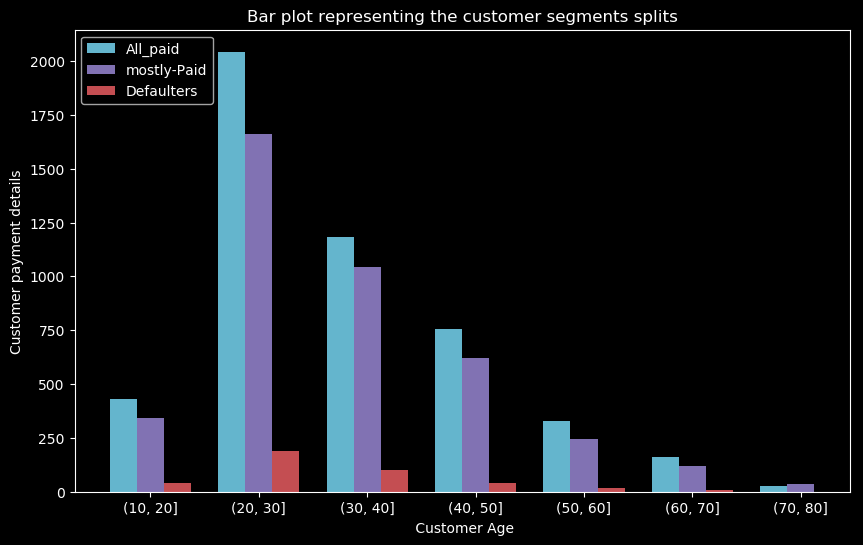

<Figure size 640x480 with 0 Axes>

In [91]:
plt.figure(figsize=[10,6])
# plt.rcParams.update(plt.rcParamsDefault)
All_paid = temp1["All-Paid"].values.tolist()
Defaulters = temp1["Defaulters"].values
mostly_Paid = temp1["mostly-Paid"].values

X = np.arange(len(All_paid))

plt.bar(X, All_paid, color = 'c', width = 0.25)
plt.bar(X + 0.25, mostly_Paid , color = 'm', width = 0.25)
plt.bar(X + 0.5, Defaulters, color = 'r', width = 0.25)

plt.legend(['All_paid', 'mostly-Paid', 'Defaulters'])

plt.xticks([i + 0.25 for i in range(7)], temp1.index.values.tolist())

plt.title("Bar plot representing the customer segments splits")

plt.xlabel(' Customer Age')
plt.ylabel('Customer payment details')
plt.style.use('dark_background')
plt.text(0.5, 0.5, '',color="white")
plt.show()

plt.savefig(os.path.join('SegmentsVsAge.png'), dpi=300, format='png', bbox_inches='tight')

In [92]:
df_Seg_kmeans.head()

,customer_id,order_amount,customer_credit_score,customer_age,paid_installment_2,paid_installment_3,paid_installment_4,approved_for_installments,checkout_started_month,checkout_started_day,segment_k-means,labels,Mean_Total_installments,agegrp
0,9D74A0,147.20,626,26,1,1.0,1.0,True,10,3,0,All-Paid,1.0,"(20, 30]"
1,2629AB,69.95,603,20,1,1.0,1.0,True,9,21,1,mostly-Paid,1.0,"(10, 20]"
2,793FE0,45.00,648,41,1,1.0,1.0,True,9,15,1,mostly-Paid,1.0,"(40, 50]"
3,22C696,164.00,625,33,1,1.0,1.0,True,10,10,0,All-Paid,1.0,"(30, 40]"
4,D4E94A,69.17,438,18,1,1.0,1.0,True,9,12,0,All-Paid,1.0,"(10, 20]"


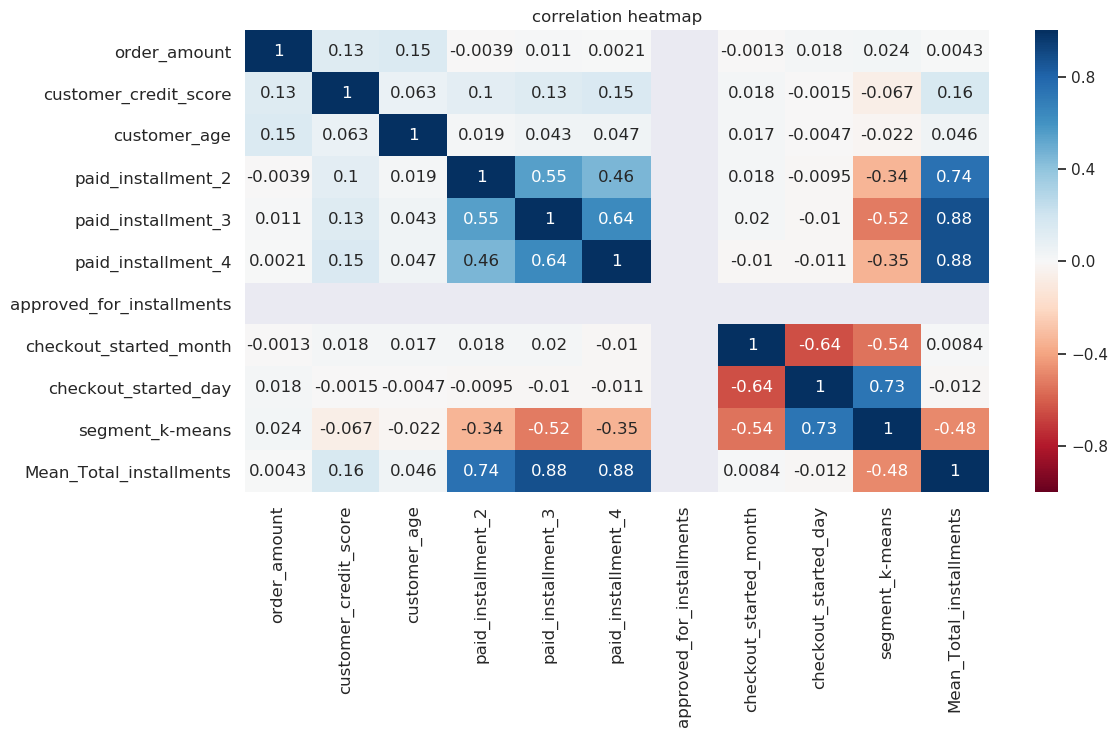

In [143]:
plt.figure(figsize=(12,6))
s=sns.heatmap(df_Seg_kmeans.corr(),
             annot=True,
             cmap='RdBu',
             vmax=-1,
             vmin=1)
s.set_yticklabels(s.get_yticklabels(),rotation=0,fontsize=12)
s.set_xticklabels(s.get_xticklabels(),rotation=90,fontsize=12)
plt.title("correlation heatmap")
plt.show()

## Modeling

In [133]:
X=df_Seg_kmeans[['order_amount', 'customer_credit_score', 'customer_age',
       'paid_installment_2', 'paid_installment_3', 'paid_installment_4']]
Y=df_Seg_kmeans["labels"].values
print(Y)

['All-Paid' 'mostly-Paid' 'mostly-Paid' ... 'All-Paid' 'mostly-Paid'
 'mostly-Paid']


In [134]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.20, random_state = 0)
classifier = DecisionTreeClassifier(criterion = 'entropy',random_state = 0)
classifier.fit(X_Train, Y_Train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [135]:
Y_Pred = classifier.predict(X_Test)
Y_Pred

array(['All-Paid', 'mostly-Paid', 'All-Paid', ..., 'All-Paid', 'All-Paid',
       'All-Paid'], dtype=object)

In [136]:
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(Y_Test, Y_Pred)))

Model accuracy score with criterion entropy: 0.5508


### comparing train and test accuracy

In [137]:
Y_Pred_Train = classifier.predict(X_Train)
class_names = ["All-Paid","Defaulters","mostly-Paid"]
Y_Pred_Train

array(['All-Paid', 'All-Paid', 'mostly-Paid', ..., 'mostly-Paid',
       'Defaulters', 'All-Paid'], dtype=object)

In [138]:
print('Training set score: {:.4f}'.format(classifier.score(X_Train, Y_Train)))
print('Test set score: {:.4f}'.format(classifier.score(X_Test, Y_Test)))

Training set score: 0.9947
Test set score: 0.5508


### confusion matrix

In [140]:
cm = confusion_matrix(Y_Test, Y_Pred)

In [142]:

df = pd.DataFrame(cm, index=class_names, columns=class_names, dtype=int)
print(df)

             All-Paid  Defaulters  mostly-Paid
All-Paid          576           0          444
Defaulters          0          80            0
mostly-Paid       400           0          379
